In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import PolynomialFeatures

from sklearn.calibration import calibration_curve

import lightgbm as lgb

from sklearn.metrics import log_loss, roc_auc_score

pd.set_option('display.max_columns', 100)

In [2]:
training_file = 'training.csv'
deploy_file = 'deploy.csv'

In [3]:
train_df = pd.read_csv(training_file)

print("the shape of the training file is:", train_df.shape)

the shape of the training file is: (10000, 5)


In [4]:
train_df.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


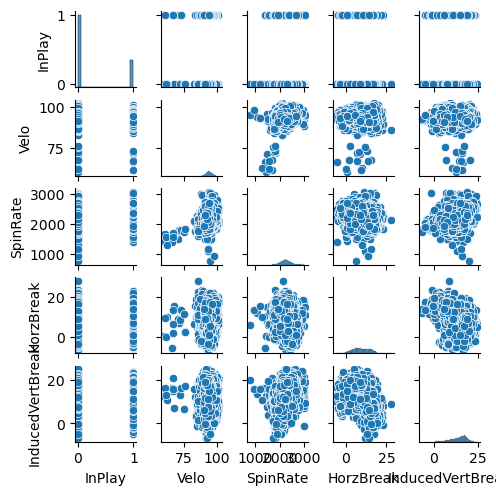

In [5]:
sns.pairplot(train_df, height=1)

In [6]:
def create_joint_plot(x=None, y=None):
    g = sns.jointplot(
        x=x,
        y=y,
        data=train_df,
        kind='hex',
        height=4
    )
    
    g.fig.suptitle(f"Interaction {x} and {y}")
    g.set_axis_labels(xlabel=x, ylabel=y)
    
    plt.show()

In [7]:
def plot_relationship(x=None, y=None):
    
    fig, ax = plt.subplots(figsize=(5,4))
    plt.hexbin(train_df[f'{x}'],
               train_df[f'{y}'],
               C=train_df['InPlay'],
               gridsize=12,
               cmap='viridis',
               reduce_C_function=np.mean)

    cb = plt.colorbar(label='InPlay')

    plt.title(f"InPlay")
    plt.xlabel(f"{x}")
    plt.ylabel(f"{y}")
    plt.show()

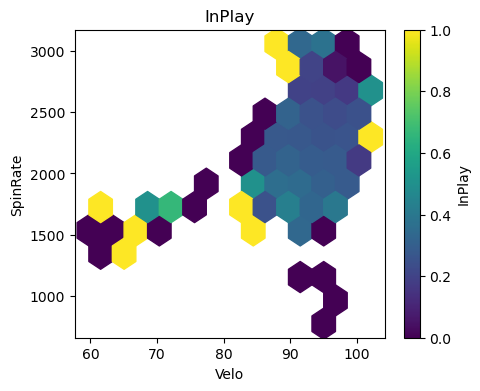

In [8]:
plot_relationship(x='Velo', y='SpinRate')

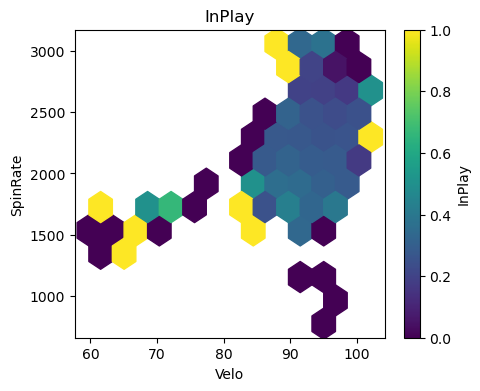

In [9]:
plot_relationship(x='Velo', y='SpinRate')

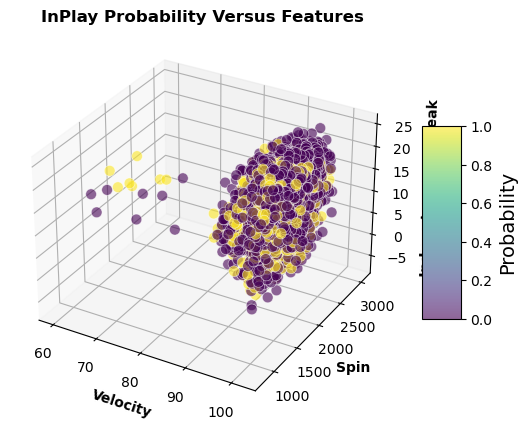

In [9]:
# creating a 3d plot to fiddle around a bit, i can't get this looking
# quite the way I want but i''d like to
fig = plt.figure(figsize=(7,5))

ax = fig.add_subplot(111, projection='3d')

sctt = ax.scatter(train_df['Velo'],
                  train_df['SpinRate'],
                  train_df['InducedVertBreak'],
                  c=train_df['InPlay'],
                  cmap='viridis',
                  s=60,
                  alpha=0.6,
                  edgecolors='w',
                  linewidth=0.5)

cbar = fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Probability', size=14)

ax.set_xlabel('Velocity', fontweight ='bold')
ax.set_ylabel('Spin', fontweight ='bold')
ax.set_zlabel('Induced Vertical Break', fontweight ='bold')
ax.set_title('InPlay Probability Versus Features', fontweight ='bold')

plt.show()


In [10]:
# are there any null values?

train_df.isnull().sum()

InPlay              0
Velo                0
SpinRate            6
HorzBreak           0
InducedVertBreak    0
dtype: int64

In [11]:
train_df['SpinRate'].fillna(train_df['SpinRate'].median(), inplace=True)

spin_rate_median_train = train_df['SpinRate'].median()

Since rows with nulls only represent 6/10000 rows, we can  
drop them without losing much information. 

I can revist this later. We could imput the values.  

In [12]:
# dropping the nas and resetting the index
train_df.dropna(inplace=True)
train_df.reset_index(drop=True, inplace=True)

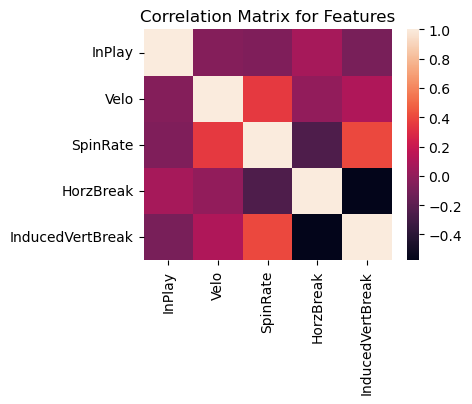

In [13]:
corr_table = train_df.corr()

fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(corr_table)

plt.title("Correlation Matrix for Features")
plt.show()

In [14]:
# the above heatmap is a bit confusing, so let's look
# at the actual values
corr_table

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
InPlay,1.000000,-0.052358,-0.065980,0.072869,-0.093320
Velo,-0.052358,1.000000,0.350879,0.001000,0.105463
SpinRate,-0.065980,0.350879,1.000000,-0.253720,0.398813
HorzBreak,0.072869,0.001000,-0.253720,1.000000,-0.577016
InducedVertBreak,-0.093320,0.105463,0.398813,-0.577016,1.000000


I thought maybe flagging some pitches as outliers, with the idea  
that out of distribution pitches may be especially easy to hit,  
would improve the models, but I didn't have much success with it.  
Discarded but kept code to demonstrate the idea.  

In [17]:
from sklearn.ensemble import IsolationForest

# i

# iso_forest = IsolationForest(contamination=0.05)
# outliers = iso_forest.fit(train_df[['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak']])

# Building a Model in Statsmodels  

In [133]:
import statsmodels.formula.api as smf


smf_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + standardize(InducedVertBreak) + \
                      I(standardize(InducedVertBreak)**2)',
                      data=train_df)

result = smf_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.578405
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 InPlay   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Thu, 31 Aug 2023   Pseudo R-squ.:                 0.01118
Time:                        20:33:25   Log-Likelihood:                -5784.0
converged:                       True   LL-Null:                       -5849.4
Covariance Type:            nonrobust   LLR p-value:                 2.686e-27
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                -0.9229      0.028    -32.940      0.000      -0.978      -0.868
standardize(Velo)                        -0.0990      0.022     -4.468      0.000      -0.142      -0.056
standardize(HorzBreak)                    0.0637      0.028      2.296      0.022       0.009       0.118
standardize(InducedVertBreak)            -0.2301      0.033     -6.994      0.000      -0.295      -0.166
I(standardize(InducedVertBreak) ** 2)    -0.0784      0.018     -4.448      0.000      -0.113      -0.044
=========================================================================================================
"""

# Training the Model  

Steps:

1. Establish a baseline using the mean probability of  
   a ball in play. 
   
   
2. Using StratifiedKFold splits I will train N models  
   and use the out of fold predictions to gauge the  
   performance of the model.
   
   
3. Assess whether the model has predictive value and  
   then use the coefficients of the linear regression  
   model to determine how best to answer the pitcher's  
   questions.  

In [16]:
# establishing a baseline that we have to beat
baseline_pred = [train_df['InPlay'].mean()] * len(train_df)

baseline_log_loss = log_loss(train_df['InPlay'], baseline_pred)
baseline_roc_auc_score = roc_auc_score(train_df['InPlay'], baseline_pred)

print("if we predicted the baseline probability for every pitch our log loss would be:", baseline_log_loss)
print("if we predicted the baseline probability for every pitch our area under the curve would be:", baseline_roc_auc_score)

if we predicted the baseline probability for every pitch our log loss would be: 0.5849423768611367
if we predicted the baseline probability for every pitch our area under the curve would be: 0.5


In [145]:
# defining the X and y that will be used to 
# train multiple models using stratifiedkfold
feature_cols = ['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak', 'under_80']

X = train_df[feature_cols].copy()
y = train_df['InPlay']


# defining a stratifiedkfold split to ensure each fold
# has the same proportion of InPlay 1s
splitter = StratifiedKFold(n_splits=12, shuffle=True)

# defining the preprocessing step. it'll be used inside
# of the pipeline within the loop to ensure there's
# no data leakage. 
linear_preprocessing = ColumnTransformer(
    transformers=[
        ('interaction', PolynomialFeatures(degree=2, include_bias=False), feature_cols)
    ],
    remainder='passthrough' 
)


all_preprocessing = Pipeline([
    ('linear_preprocess', linear_preprocessing),
    ('scale', StandardScaler())
])

# initializing an array to store the out of fold predictions
oof_preds = np.zeros(len(train_df))
lgb_oof_preds = np.zeros(len(train_df))
sm_oof_preds = np.zeros(len(train_df))

# initializing lists to store the models
linear_models = []
lgb_models = []

for train, val in splitter.split(X, y):
    
    train_x = X.iloc[train]
    train_y = y[train]
    
    val_x = X.iloc[val]
    val_y = y[val]
    
    
    pipeline = pipeline = Pipeline([
    ('preprocess', all_preprocessing),
    ('classifier', LogisticRegression(penalty='l1', solver='saga', max_iter=5000))]
)
    
    lgb_pipeline = Pipeline([
        ('gbt_classifier', lgb.LGBMClassifier(max_depth=2))
    ])
    
    for_smf = pd.concat([train_x, train_y], axis=1)
    
    smf_model = smf.logit('InPlay ~ standardize(Velo) + standardize(HorzBreak) + standardize(InducedVertBreak) + \
                      I(standardize(InducedVertBreak)**2)',
                      data=for_smf)

    result = smf_model.fit()
    
    statsmod_preds = result.predict(val_x)
    
    pipeline.fit(train_x, train_y)
    lgb_pipeline.fit(train_x, train_y)
    
    preds = pipeline.predict_proba(val_x)[:,1]
    lgb_preds = lgb_pipeline.predict_proba(val_x)[:, 1]
    
    linear_models.append(pipeline)
    lgb_models.append(lgb_pipeline)
    
    oof_preds[val] = preds
    lgb_oof_preds[val] = lgb_preds
    sm_oof_preds[val] = statsmod_preds

Optimization terminated successfully.
         Current function value: 0.578755
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.579212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.578570
  

# Examining the Out of Fold Predictions  

In [146]:
train_df['linear_preds'] = oof_preds
train_df['lgb_preds'] = lgb_oof_preds
train_df['sm_preds'] = sm_oof_preds

In [147]:
linear_log_loss_oof = log_loss(y, oof_preds)
linear_roc_auc_score = roc_auc_score(y, oof_preds)

gbt_log_loss_oof = log_loss(y, lgb_oof_preds)
gbt_roc_auc_score = roc_auc_score(y, lgb_oof_preds)

sm_log_loss_oof = log_loss(y, sm_oof_preds)
sm_roc_auc_score = roc_auc_score(y, sm_oof_preds)

model_perf = (
    pd.DataFrame({
        'baseline_logloss' : baseline_log_loss, 
        'baseline_rocscore' : baseline_roc_auc_score,
        'sklinear_logloss' : linear_log_loss_oof,
        'gbt_logloss' : gbt_log_loss_oof,
        'sm_logloss' : sm_log_loss_oof,
        'sklinear_rocscore' : linear_roc_auc_score,
        'gbt_rocscore': gbt_roc_auc_score,
        'sm_rocscore' : sm_roc_auc_score}, index=[0])
)

model_perf

,baseline_logloss,baseline_rocscore,sklinear_logloss,gbt_logloss,sm_logloss,sklinear_rocscore,gbt_rocscore,sm_rocscore
0,0.584942,0.5,0.580078,0.579999,0.578905,0.570465,0.562582,0.571324


In [138]:
from sklearn.metrics import roc_curve, auc

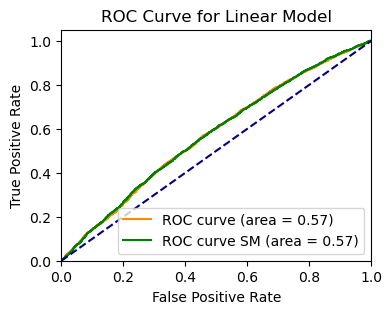

In [139]:
# get the roc curve
fpr, tpr, thresholds = roc_curve(y, oof_preds)
sm_fpr, sm_tpr, thresholds = roc_curve(y, sm_oof_preds)

plt.figure(figsize=(4, 3))

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {linear_roc_auc_score:.2f})')
plt.plot(sm_fpr, sm_tpr, color='green', label=f'ROC curve SM (area = {sm_roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curve for Linear Model')

plt.legend(loc="lower right")
plt.show()

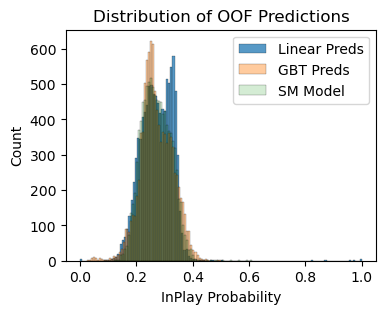

In [141]:
fig, ax = plt.subplots(figsize=(4,3))

sns.histplot(train_df['linear_preds'], label='Linear Preds')
sns.histplot(train_df['lgb_preds'], label='GBT Preds', alpha=0.4)
sns.histplot(train_df['sm_preds'], label='SM Model', alpha=0.2)


plt.title("Distribution of OOF Predictions")
plt.xlabel("InPlay Probability")
plt.legend()
plt.show()

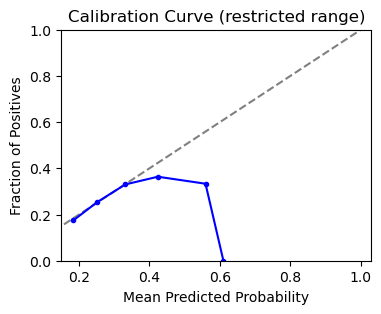

In [142]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y, sm_oof_preds, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(4,3))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.plot(prob_pred, prob_true, marker='.', color='b')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (restricted range)')
plt.xlim([0.15, train_df['linear_preds'].max() + 0.03])
plt.ylim([0, 1])
plt.show()

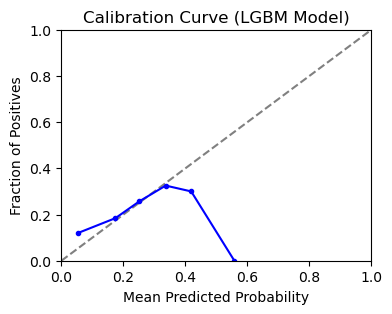

In [24]:
# Compute calibration curve
prob_true, prob_pred = calibration_curve(y, lgb_oof_preds, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(4,3))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.plot(prob_pred, prob_true, marker='.', color='b')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (LGBM Model)')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Why are the probabilities miscalbrated above ~0.35?  

How many are there? Let's try another tool that includes  
the confidence interval.  

In [25]:
from sklearn.isotonic import IsotonicRegression
import ml_insights as mli

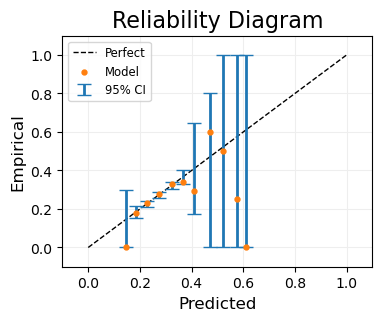

In [143]:
fig, ax = plt.subplots(figsize=(4,3))
mli.plot_reliability_diagram(y, sm_oof_preds, marker='.')
plt.show()

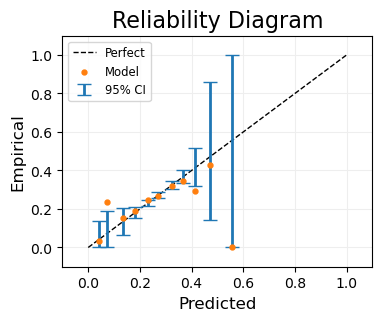

In [27]:
fig, ax = plt.subplots(figsize=(4,3))
mli.plot_reliability_diagram(y, lgb_oof_preds, marker='.')
plt.show()

# Extracting Coefficients  

Getting the coefficients from the model to interpret them  
so I can offer the pitcher some advice.  

In [63]:
linear_coeffs = []
linear_intercepts = []

for model in linear_models:
    # get the coefficients
    coeffs = model.named_steps['classifier'].coef_[0]
    # get the intercepts
    intercept = model.named_steps['classifier'].intercept_[0]
    
    # append to the lists
    linear_coeffs.append(coeffs)
    linear_intercepts.append(intercept)

# getting poly features
poly_feature_names = (
    linear_models[0]
    .named_steps['preprocess']
    .named_steps['linear_preprocess']
    .named_transformers_['interaction']
    .get_feature_names_out(input_features=feature_cols)
)


In [64]:
coef_df = pd.DataFrame.from_records(linear_coeffs)
coef_df.columns = poly_feature_names

# getting the mean coefficients for now
coef_df.mean()

Velo                          0.224345
SpinRate                      0.073581
HorzBreak                    -0.889227
InducedVertBreak              0.113355
under_80                     -0.083311
Velo^2                       -0.333781
Velo SpinRate                 0.103941
Velo HorzBreak                0.395560
Velo InducedVertBreak        -0.376548
Velo under_80                -0.843573
SpinRate^2                   -0.330365
SpinRate HorzBreak            0.350510
SpinRate InducedVertBreak     0.303408
SpinRate under_80            -0.001809
HorzBreak^2                   0.027178
HorzBreak InducedVertBreak    0.153941
HorzBreak under_80            0.091813
InducedVertBreak^2           -0.308191
InducedVertBreak under_80     0.929691
under_80^2                   -0.083311
dtype: float64

# Creating a Bayesian Model  

Setting up a simple Bayesian model to model the uncertainty  
in the parameters and use its tools to extract partial  
correlation, among other things.  

I am on a laptop and I cannot do this in the time allotted,  
but it's here because I'd like to.  

In [34]:
import arviz as az
import bambi as bmb

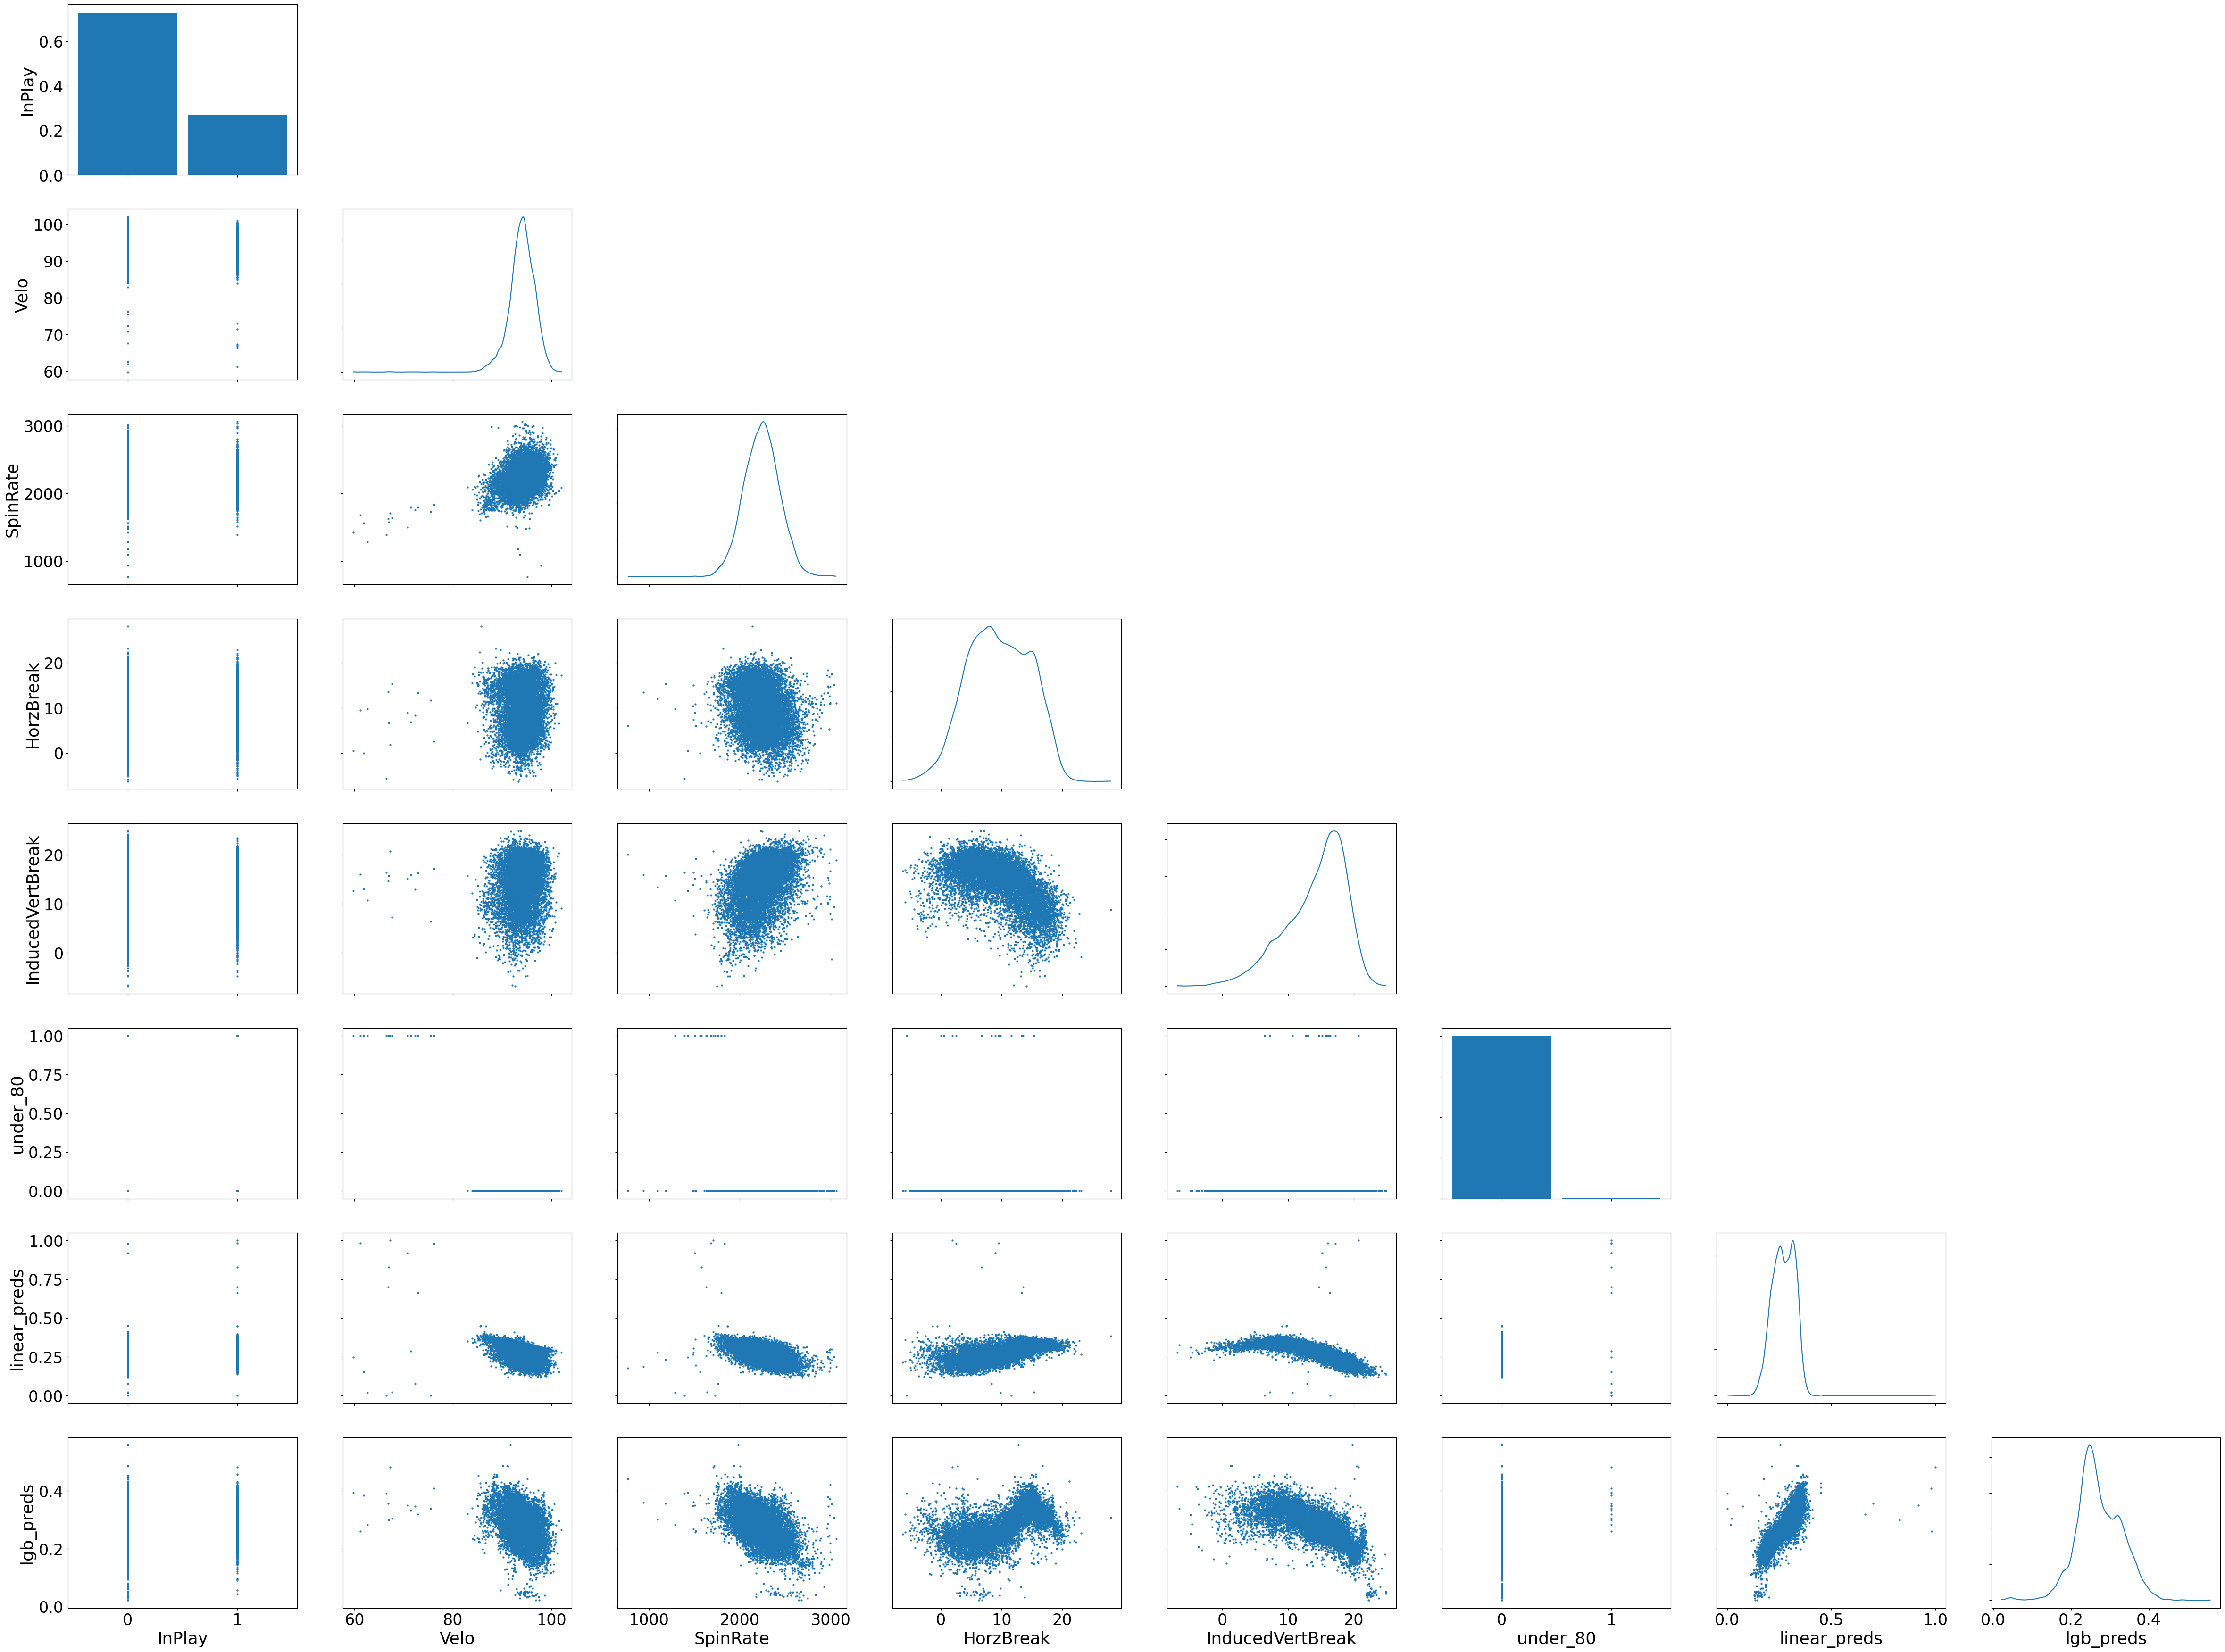

In [35]:
az.plot_pair(train_df.to_dict("list"), marginals=True, textsize=24);

In [79]:
smaller_sample = train_df.sample(1500)

model = bmb.Model('InPlay ~ Velo + SpinRate + HorzBreak + InducedVertBreak', data=smaller_sample, family='bernoulli')

results = model.fit(draws=1000, chains=2, target_accept=0.95,)

Modeling the probability that InPlay==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, Velo, SpinRate, HorzBreak, InducedVertBreak]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1258 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [82]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1110.944,138.646,-1341.803,-892.276,95.133,79.566,2.0,11.0,3.04
Velo,0.371,0.106,0.265,0.478,0.075,0.063,3.0,11.0,2.11
SpinRate,0.479,0.061,0.383,0.581,0.042,0.035,2.0,11.0,3.03
HorzBreak,0.729,0.254,0.475,0.982,0.179,0.151,3.0,12.0,2.06
InducedVertBreak,-0.386,0.338,-0.725,-0.048,0.238,0.202,3.0,12.0,2.22


# Meta Model for Predictions  

In [43]:
# for the sake of the model predictions, i'm going to train a model
# on the entire set of out of fold predictions, including the gbt

meta_model_X = train_df[['linear_preds', 'lgb_preds']].copy()
meta_model_y = y

meta_model = LogisticRegression()

meta_model.fit(meta_model_X, meta_model_y)

LogisticRegression()

In [81]:
meta_model.coef_

array([[2.88747646, 1.406369  ]])

In [96]:
feature_cols

['Velo', 'SpinRate', 'HorzBreak', 'InducedVertBreak', 'under_80']

# Predicting on Deploy  

In [44]:
deploy_df = pd.read_csv('deploy.csv')

deploy_df.head()

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,94.72,2375.0,3.10,18.15
1,95.25,2033.0,11.26,14.50
2,92.61,2389.0,11.00,21.93
3,94.94,2360.0,6.84,18.11
4,97.42,2214.0,16.70,13.38


In [45]:
deploy_df.isnull().sum()

Velo                 0
SpinRate            13
HorzBreak            0
InducedVertBreak     0
dtype: int64

In [46]:
# filling in the null in deploy using the median from train
# this is the right way to do it

In [47]:
deploy_df['SpinRate'].fillna(spin_rate_median_train, inplace=True)
deploy_df['under_80'] = np.where(deploy_df['Velo'] <= 80, 1, 0)

In [48]:
linear_preds_deploy = linear_models[0].predict_proba(deploy_df)[:,1]
gbt_preds_deploy = lgb_models[0].predict_proba(deploy_df)[:,1]

stacked_preds_df = pd.DataFrame({
    'linear_preds': linear_preds_deploy,
    'lgb_preds': gbt_preds_deploy
})

meta_preds = meta_model.predict_proba(stacked_preds_df)[:,1]

In [49]:
deploy_df['PredInPlayProbability'] = meta_preds

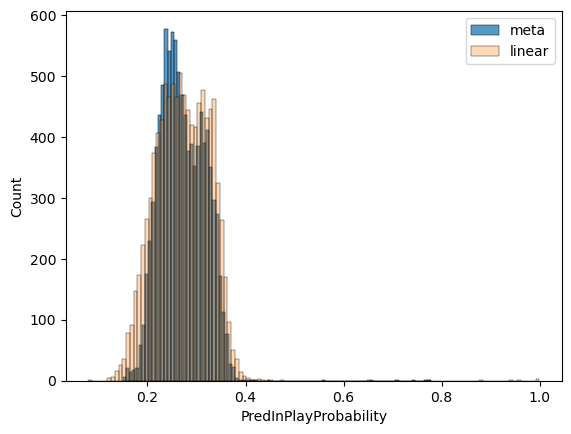

In [50]:
sns.histplot(deploy_df['PredInPlayProbability'], label='meta')
sns.histplot(linear_preds_deploy, label='linear', alpha=0.3)

plt.legend()
plt.show()

In [52]:
deploy_df['PredInPlayProbability'].to_csv('predictions.csv')

In [99]:
# getting the mean coefficients for now
coef_df.mean()

Velo                          0.163383
SpinRate                      0.141774
HorzBreak                    -0.790697
InducedVertBreak              0.402237
Velo^2                       -0.233521
Velo SpinRate                 0.046527
Velo HorzBreak                0.312055
Velo InducedVertBreak        -0.652223
SpinRate^2                   -0.335877
SpinRate HorzBreak            0.331250
SpinRate InducedVertBreak     0.261377
HorzBreak^2                   0.028082
HorzBreak InducedVertBreak    0.159255
InducedVertBreak^2           -0.288004
dtype: float64

These are in z-scores, so we're talking about changes in the standard  
deviation of the features.  

They're also interpreted in terms of log-odds.  

Largest positive impact, iow these increase the probability of a ball in play:  

- InducedVertBreak
- VeloHorzBreak 
- SpinRate/HorzBreak interaction,  
- Spin/InducedVertBreak

Largest negative impact, iow these decrease the probability of a ball in play:  

- Velo and InducedVertBreak
- Spin Rate Squared (increases as it increases)
- Velo Squared (increases as it increases)
- Horz Break (really increases) 
- Induced VertBreak squared

In [67]:
coef_dict = coef_df.mean().to_dict()

In [70]:
def compute_probability(coefficient, value):
    logit = -1.005 + coef_dict[coefficient] * value
    return np.exp(logit) / (1 + np.exp(logit))

In [80]:
compute_probability('Velo^2', 2)

0.15808279596746122